importing packages & files

In [220]:
# import packages, files

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

census_df = pd.read_excel('../Data/census_data.xls', sheet_name='est22ALL', skiprows=3, engine='xlrd')

graduation_df = pd.read_excel('../Data/graduation_rates.xlsx', sheet_name='Data')

library_df = pd.read_excel('../Data/library_data.xlsx', sheet_name='PLS_FY22_AE_pud22i')

create primary keys for join

In [221]:
# align dataframes for merging across counties
# using keys "state", "county"
# no trailing whitespace, all lowercase

# graduation file needs to have state extracted, words like "county" removed

graduation_df['STATE'] = graduation_df['COUNTY'].str.extract(r",\s*([A-Z]{2})$")
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*County,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Municipality,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough/.*", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Census( Area)?", "", regex=True)


for col in graduation_df.columns:
    if graduation_df[col].dtype == 'object': 
        graduation_df[col] = graduation_df[col].str.lower().str.strip()
        
# library file needs to be made lowercase

library_df.rename(columns={'STABR': 'STATE', 'CNTY': 'COUNTY'}, inplace=True)
library_df['STATE'] = library_df['STATE'].str.lower().str.strip()
library_df['COUNTY'] = library_df['COUNTY'].str.lower().str.strip()

# census file needs to have state extracted, words like "county" removed

census_df.rename(columns={'Postal Code': 'STATE', 'Name': 'COUNTY'}, inplace=True)
census_df['COUNTY'] = census_df['COUNTY'].str.replace(r"\s*(County|Borough|Municipality|Census( Area)?)", "", regex=True)

census_df['STATE'] = census_df['STATE'].str.lower().str.strip()
census_df['COUNTY'] = census_df['COUNTY'].str.lower().str.strip()

rename & select columns

In [222]:
# select and rename relevant columns before merging

graduation_df.columns = graduation_df.columns.astype(str)

print(graduation_df.columns)

graduation_df = graduation_df[['STATE', 'COUNTY', '2022-01-01 00:00:00']]
graduation_df.rename(columns={'2022-01-01 00:00:00': 'grad_rate'}, inplace=True)

library_df = library_df[['STATE', 'COUNTY', 'CNTYPOP', 'VISITS', 'REGBOR', 'TOTINCM', 'TOTPRO', 'TOTSTAFF', 'TOTCIR', 'CENTLIB', 'BRANLIB']]

# Identify the columns to transform
columns_to_lower = library_df.columns[2:]  # From 'POPU_LSA' onwards

# Convert these columns to lowercase
library_df.rename(columns={col: col.lower() for col in columns_to_lower}, inplace=True)

# drop blank columns

census_df = census_df[(census_df['90% CI Upper Bound.6'] != ".") & 
                      (census_df['90% CI Lower Bound.6'] != ".")]

# Ensure columns are cast to float before subtraction
census_df['90% CI Upper Bound.6'] = census_df['90% CI Upper Bound.6'].astype(float)
census_df['90% CI Lower Bound.6'] = census_df['90% CI Lower Bound.6'].astype(float)

# create variable "income_range"
census_df['income_range'] = census_df['90% CI Upper Bound.6'] - census_df['90% CI Lower Bound.6']

census_df = census_df[['STATE', 'COUNTY', 'Poverty Percent, Age 5-17 in Families', 'Median Household Income', 'income_range']]

census_df.rename(columns={'Poverty Percent, Age 5-17 in Families':'poverty_percent', 'Median Household Income':'med_income'}, inplace=True)

print('lib')
print(library_df)
print('census')
print(census_df)
print('grad')
print(graduation_df)

Index(['COUNTY', 'CODE', '2010-01-01 00:00:00', '2011-01-01 00:00:00',
       '2012-01-01 00:00:00', '2013-01-01 00:00:00', '2014-01-01 00:00:00',
       '2015-01-01 00:00:00', '2016-01-01 00:00:00', '2017-01-01 00:00:00',
       '2018-01-01 00:00:00', '2019-01-01 00:00:00', '2020-01-01 00:00:00',
       '2021-01-01 00:00:00', '2022-01-01 00:00:00', 'STATE'],
      dtype='object')
lib
     STATE             COUNTY  cntypop  visits  regbor  totincm  totpro  \
0       ak    kenai peninsula    59767    5127    1950    71874     150   
1       ak          anchorage   288121  261807  123846  9357471     758   
2       ak             denali     1593     421     138    13885      -1   
3       ak             bethel    18557   12817    2062   138115      80   
4       ak  matanuska-susitna   110686   27063    2867   417502     249   
...    ...                ...      ...     ...     ...      ...     ...   
9243    wy           sublette     8697   96858    4525  1077591     689   
9244    wy  

merge columns. left joined on graduation data

In [223]:
# First, left join graduation_df (left) with library_df (right)
merged_df = graduation_df.merge(library_df, on=['STATE', 'COUNTY'], how='left')

# Then, left join the result with census_df (right)
merged_df = merged_df.merge(census_df, on=['STATE', 'COUNTY'], how='left')

# Print the resulting DataFrame
print(merged_df)
# Select columns to convert (exclude 'STATE' and 'COUNTY')
columns_to_convert = merged_df.columns.difference(['STATE', 'COUNTY'])

# Convert selected columns to float
merged_df[columns_to_convert] = merged_df[columns_to_convert].astype(float)

# Verify the conversion
print(merged_df.dtypes)

# Count rows with null values
rows_with_nulls = merged_df.isnull().any(axis=1).sum()

# Count rows without null values
rows_without_nulls = (~merged_df.isnull().any(axis=1)).sum()

# Print the results
print(f"Number of rows with null values: {rows_with_nulls}")
print(f"Number of rows without null values: {rows_without_nulls}")



     STATE     COUNTY  grad_rate   cntypop    visits   regbor    totincm  \
0       al    autauga       90.4   59095.0   62905.0  32024.0   663391.0   
1       al    baldwin       91.6  239294.0   10000.0   2316.0   310021.0   
2       al    baldwin       91.6  239294.0  102903.0  14589.0  1208716.0   
3       al    baldwin       91.6  239294.0  156951.0  19876.0   930410.0   
4       al    baldwin       91.6  239294.0  137258.0  16302.0  1126338.0   
...    ...        ...        ...       ...       ...      ...        ...   
9636    pr  vega baja       76.7       NaN       NaN      NaN        NaN   
9637    pr    vieques       72.3       NaN       NaN      NaN        NaN   
9638    pr   villalba       78.9       NaN       NaN      NaN        NaN   
9639    pr    yabucoa       74.8       NaN       NaN      NaN        NaN   
9640    pr      yauco       79.0   32904.0      -1.0     -1.0       -1.0   

      totpro  totstaff    totcir  centlib  branlib poverty_percent med_income  \
0     

deal with null, negative values. 

THIS AREA MAY NEED ADJUSTMENTS FOR IMPUTATIONS

In [224]:
# deal with null columns, missing columns (imputation)
# may need more refined future approach

# Drop rows with null values
filtered_df = merged_df.dropna()

# Define the columns to check (exclude 'STATE' and 'COUNTY')
columns_to_check = filtered_df.columns.difference(['STATE', 'COUNTY'])

# Drop rows with null values in the selected columns
filtered_df = filtered_df.dropna(subset=columns_to_check)

# Drop rows with negative values in the selected columns
filtered_df = filtered_df[(filtered_df[columns_to_check] >= 0).all(axis=1)]

# Print the resulting DataFrame
print(f"Number of rows after filtering: {len(filtered_df)}")
print(filtered_df)

Number of rows after filtering: 8401
     STATE      COUNTY  grad_rate   cntypop    visits   regbor    totincm  \
0       al     autauga       90.4   59095.0   62905.0  32024.0   663391.0   
1       al     baldwin       91.6  239294.0   10000.0   2316.0   310021.0   
2       al     baldwin       91.6  239294.0  102903.0  14589.0  1208716.0   
3       al     baldwin       91.6  239294.0  156951.0  19876.0   930410.0   
4       al     baldwin       91.6  239294.0  137258.0  16302.0  1126338.0   
...    ...         ...        ...       ...       ...      ...        ...   
9555    wy  sweetwater       93.0   41614.0  222458.0  31288.0  3246411.0   
9556    wy       teton       96.0   23575.0  124903.0  17071.0  4099837.0   
9557    wy       uinta       94.4   20635.0   71067.0  11107.0   526251.0   
9558    wy    washakie       94.7    7705.0   44650.0   6850.0   316001.0   
9559    wy      weston       91.1    6745.0   25230.0   5056.0   325212.0   

      totpro  totstaff    totcir  cent

variables:
- STATE, COUNTY --> primary key
- grad_rate --> high school grad rate (%)
- cntypop --> population of county (should be same across)
- visits --> num visits in year (sum across library systems in county)
- regbor --> registered users (sum across all library systems in county? problem is people can be registered in more than one library)
- locgvt --> local government revenue (sum across? needs more analysis based off imputation methods)
- totpro --> total programs (sum across library systems)
- totstaff --> total staff (sum across library systems)
- totcir --> total circulation (sum across library systems in county)
- centlib --> num central libraries in system (sum across)
- branlib --> num bran libraries in systems (sum across)
- poverty_percent --> % in poverty in county (will be same across)
- med_income --> median household income (will be same across)
- income_range --> dif in 90% upper/lower household income in county (will be same across)




In [225]:
# aggregate columns according to above

# Define aggregation logic for each column
aggregation_logic = {
    'grad_rate': 'first',  # Average graduation rate
    'cntypop': 'first',  # Total population
    'visits': 'sum',  # Total visits across systems
    'regbor': 'sum',  # Total registered borrowers (note possible duplicates)
    'totincm': 'sum',  # Total revenues
    'totpro': 'sum',  # Total programs offered
    'totstaff': 'sum',  # Total staff across systems
    'totcir': 'sum',  # Total circulation
    'centlib': 'sum',  # Total number of central libraries
    'branlib': 'sum',  # Total number of branch libraries
    'poverty_percent': 'first',  # Same across rows, use first occurrence
    'med_income': 'first',  # Same across rows, use first occurrence
    'income_range': 'first'  # Same across rows, use first occurrence
}

# Group by STATE and COUNTY and apply aggregation logic
aggregated_df = filtered_df.groupby(['STATE', 'COUNTY'], as_index=False).agg(aggregation_logic)

# Print the resulting aggregated DataFrame
print(aggregated_df)


     STATE                COUNTY  grad_rate   cntypop    visits    regbor  \
0       ak        aleutians east       81.0    3398.0    1196.0     136.0   
1       ak             anchorage       94.2  288121.0  261807.0  123846.0   
2       ak           bristol bay       95.0     838.0    7359.0     407.0   
3       ak                denali       96.7    1593.0    1642.0    1227.0   
4       ak  fairbanks north star       94.7   95593.0  203237.0   42522.0   
...    ...                   ...        ...       ...       ...       ...   
2538    wy            sweetwater       93.0   41614.0  222458.0   31288.0   
2539    wy                 teton       96.0   23575.0  124903.0   17071.0   
2540    wy                 uinta       94.4   20635.0   71067.0   11107.0   
2541    wy              washakie       94.7    7705.0   44650.0    6850.0   
2542    wy                weston       91.1    6745.0   25230.0    5056.0   

        totincm  totpro  totstaff    totcir  centlib  branlib  \
0       42

In [226]:
# check percent of column that value is zero for 
# Calculate percentage of zeros in each column
zero_percentages = {}
for col in aggregated_df.columns:
    zero_count = (aggregated_df[col] == 0).sum()
    zero_percentage = (zero_count / len(aggregated_df)) * 100
    zero_percentages[col] = zero_percentage

# Display results
for col, pct in zero_percentages.items():
    print(f"Column {col}: {pct:.2f}% zeros")

Column STATE: 0.00% zeros
Column COUNTY: 0.00% zeros
Column grad_rate: 0.00% zeros
Column cntypop: 0.00% zeros
Column visits: 0.04% zeros
Column regbor: 0.00% zeros
Column totincm: 0.00% zeros
Column totpro: 0.90% zeros
Column totstaff: 0.04% zeros
Column totcir: 0.04% zeros
Column centlib: 3.19% zeros
Column branlib: 56.27% zeros
Column poverty_percent: 0.00% zeros
Column med_income: 0.00% zeros
Column income_range: 0.00% zeros


convert relevant metrics to per capita

In [227]:
# convert some columns to per capita

# Define the columns to convert to per capita
columns_to_convert = ['centlib', 'branlib', 'visits', 'regbor', 'totincm', 'totpro', 'totstaff', 'totcir']

# Convert to per capita by dividing each column by 'popu_lsa'
for col in columns_to_convert:
    aggregated_df[col + '_per_capita'] = aggregated_df[col] / aggregated_df['cntypop']

# Count rows with any null values
rows_with_nulls = aggregated_df.isnull().any(axis=1).sum()

print(f"Number of rows with null values: {rows_with_nulls}")

# Drop the original columns (optional)
aggregated_df.drop(columns=columns_to_convert, inplace=True)

aggregated_df.drop(columns=['cntypop'], inplace=True)

# Inspect the result
print(aggregated_df.head())

Number of rows with null values: 0
  STATE                COUNTY  grad_rate  poverty_percent  med_income  \
0    ak        aleutians east       81.0             13.5     85852.0   
1    ak             anchorage       94.2             10.4     99162.0   
2    ak           bristol bay       95.0             13.7     96382.0   
3    ak                denali       96.7              9.7     90897.0   
4    ak  fairbanks north star       94.7              8.0     84166.0   

   income_range  centlib_per_capita  branlib_per_capita  visits_per_capita  \
0       20864.0            0.000294            0.000000           0.351972   
1        8116.0            0.000003            0.000014           0.908670   
2       24492.0            0.001193            0.001193           8.781623   
3       19790.0            0.001255            0.000000           1.030760   
4       15140.0            0.000010            0.000010           2.126066   

   regbor_per_capita  totincm_per_capita  totpro_per_capi

create correlation matrix

C:\Users\Chris\AppData\Local\Temp\ipykernel_22880\485770921.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = aggregated_df.corr()


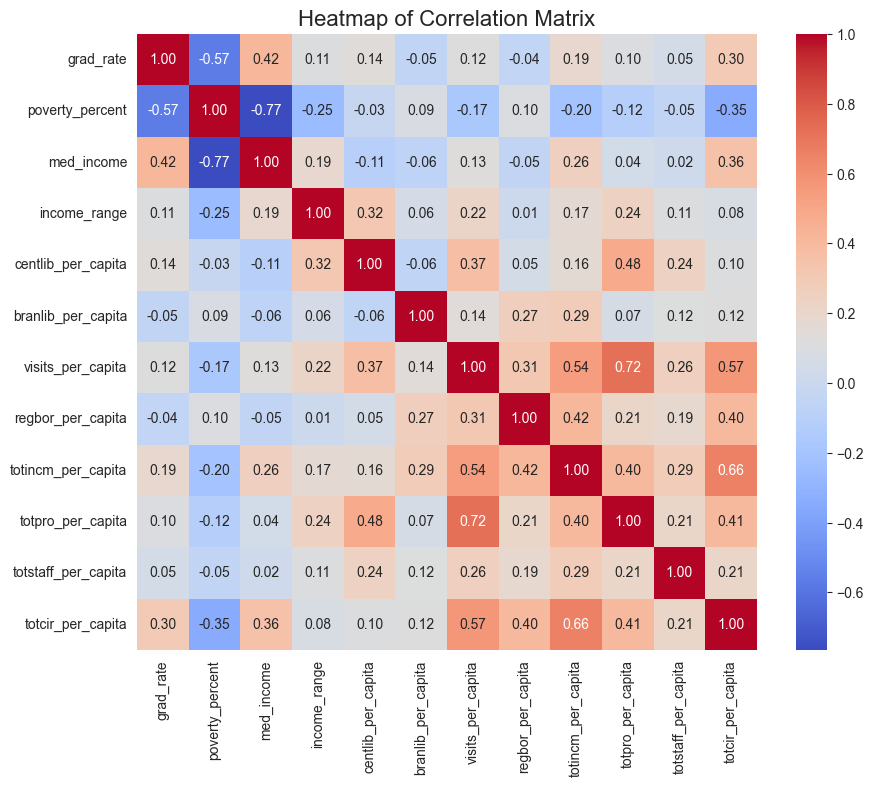

In [228]:
# Calculate the correlation matrix
corr_matrix = aggregated_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title("Heatmap of Correlation Matrix", fontsize=16)
plt.show()

scale data to prepare for regularized regression models

In [229]:
# Assuming aggregated_df is ready and cleaned

# Select features (X) and target variable (y)
X = aggregated_df.drop(columns=['STATE', 'COUNTY', 'grad_rate'])  # Drop non-numerical and target
y = aggregated_df['grad_rate']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [230]:
# Lasso regression with cross-validation
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=20, random_state=42)
lasso.fit(X_train, y_train)

# Lasso performance
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)

lasso_train_error = mean_squared_error(y_train, lasso_train_pred)
lasso_test_error = mean_squared_error(y_test, lasso_test_pred)

print("Lasso Regression")
print(f"Best Alpha: {lasso.alpha_}")
print(f"Train Error (MSE): {lasso_train_error}")
print(f"Test Error (MSE): {lasso_test_error}")


Lasso Regression
Best Alpha: 0.09770099572992257
Train Error (MSE): 19.09954694822797
Test Error (MSE): 19.234876948531618


In [231]:
# Ridge regression with cross-validation
ridge = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=20)
ridge.fit(X_train, y_train)

# Ridge performance
ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)

ridge_train_error = mean_squared_error(y_train, ridge_train_pred)
ridge_test_error = mean_squared_error(y_test, ridge_test_pred)

print("\nRidge Regression")
print(f"Best Alpha: {ridge.alpha_}")
print(f"Train Error (MSE): {ridge_train_error}")
print(f"Test Error (MSE): {ridge_test_error}")


Ridge Regression
Best Alpha: 37.649358067924716
Train Error (MSE): 18.960192961405163
Test Error (MSE): 19.0940323746114


observe weights and selected features of lasso

In [232]:
print("Lasso Selected Features:", np.array(X.columns)[lasso.coef_ != 0])
# Get the feature names from the original DataFrame (excluding target and non-numeric columns)
feature_names = X.columns

# Extract the coefficients from the trained Lasso model
lasso_coefficients = lasso.coef_

# Combine feature names and coefficients into a DataFrame for better readability
lasso_weights = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

# Sort by absolute coefficient value (optional, for interpretability)
lasso_weights = lasso_weights.reindex(lasso_weights['Coefficient'].abs().sort_values(ascending=False).index)

# Print the weights
print("Lasso Regression Coefficients:")
print(lasso_weights)

Lasso Selected Features: ['poverty_percent' 'income_range' 'centlib_per_capita' 'visits_per_capita'
 'regbor_per_capita' 'totincm_per_capita' 'totcir_per_capita']
Lasso Regression Coefficients:
                Feature  Coefficient
0       poverty_percent    -2.952478
10    totcir_per_capita     0.652378
3    centlib_per_capita     0.644732
5     visits_per_capita    -0.365496
2          income_range    -0.285972
6     regbor_per_capita    -0.057706
7    totincm_per_capita     0.027759
1            med_income     0.000000
4    branlib_per_capita    -0.000000
8     totpro_per_capita    -0.000000
9   totstaff_per_capita    -0.000000


distribution of outcomes. ensuring that they fall between 0-100

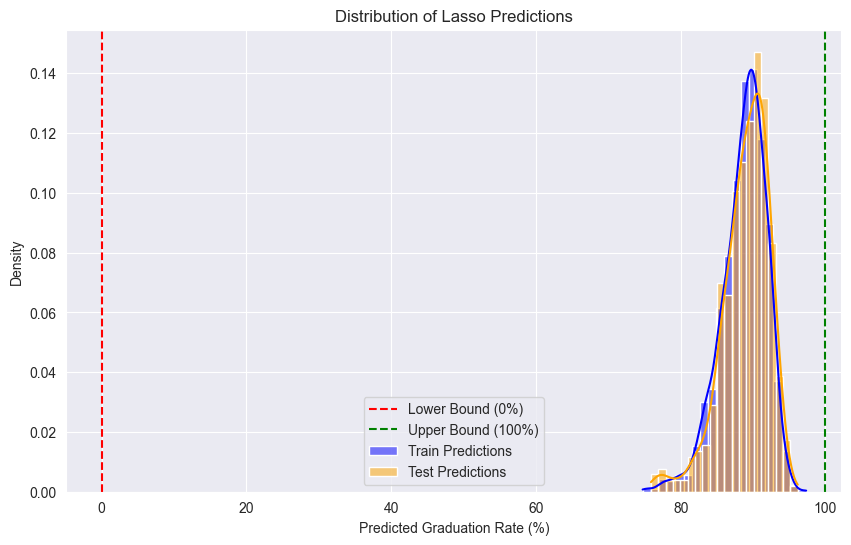

In [233]:
# Get predictions for train and test data
train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

# Plot distribution for train predictions
plt.figure(figsize=(10, 6))
sns.histplot(train_predictions, bins=20, kde=True, color='blue', label='Train Predictions', stat="density")
sns.histplot(test_predictions, bins=20, kde=True, color='orange', label='Test Predictions', stat="density")

# Add labels and title
plt.axvline(0, color='red', linestyle='--', label='Lower Bound (0%)')
plt.axvline(100, color='green', linestyle='--', label='Upper Bound (100%)')
plt.xlabel('Predicted Graduation Rate (%)')
plt.ylabel('Density')
plt.title('Distribution of Lasso Predictions')
plt.legend()
plt.show()